# 1. 数据预处理
## 检查并处理缺失值
首先，我们需要加载乳腺癌数据集并检查是否有缺失值。

In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

# 加载数据集
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# 检查缺失值
print(df.isnull().sum())

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64


## 标准化或归一化数据
通常我们使用标准化方法对数据进行处理。

In [2]:
from sklearn.preprocessing import StandardScaler

# 标准化特征数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[data.feature_names])
y = df['target']

# 2. 交叉验证
使用 k-fold 交叉验证来评估模型的泛化能力。

In [3]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

# 定义 SVM 模型
svm_model = SVC()

# 使用 10-fold 交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_scaled, y, cv=cv)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")

Cross-validation scores: [1.         0.98245614 0.94736842 0.96491228 0.96491228 0.96491228
 1.         0.94736842 0.98245614 1.        ]
Mean CV score: 0.9754385964912281


# 3. 超参数优化
使用 Bayesian Optimization 来选择 SVM 模型的最佳超参数。

In [4]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# 定义参数搜索空间
param_grid = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'degree': Integer(1, 8),
    'coef0': Real(0, 10)
}

# 使用 Bayesian Optimization 进行超参数搜索
bayes_search = BayesSearchCV(estimator=SVC(), search_spaces=param_grid, n_iter=32, cv=cv, random_state=42, n_jobs=-1)
bayes_search.fit(X_scaled, y)

print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best CV score: {bayes_search.best_score_}")

Best parameters: OrderedDict({'C': 0.21776603694820984, 'coef0': 9.18722521669377, 'degree': 2, 'gamma': 0.0010797659128262546, 'kernel': 'linear'})
Best CV score: 0.9754385964912281


# 4. 模型评估
计算各种评估指标，包括 Accuracy, Sensitivity, Specificity, ROC 曲线和 AUC 等。

Accuracy: 0.9859402460456942
Precision: 0.9833795013850416
Recall: 0.9943977591036415
Confusion Matrix: 
[[206   6]
 [  2 355]]
AUC: 0.9966703662597114


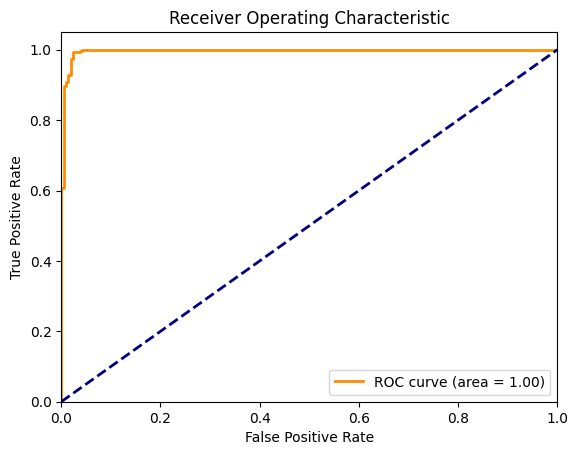

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# 最佳模型
best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_scaled)

# 评估指标
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# ROC 曲线和 AUC
fpr, tpr, _ = roc_curve(y, best_model.decision_function(X_scaled))
roc_auc = auc(fpr, tpr)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"AUC: {roc_auc}")

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 5. 特征重要性分析
使用 SHAP 分析特征的重要性和对模型预测的影响。

Using 569 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/569 [00:00<?, ?it/s]

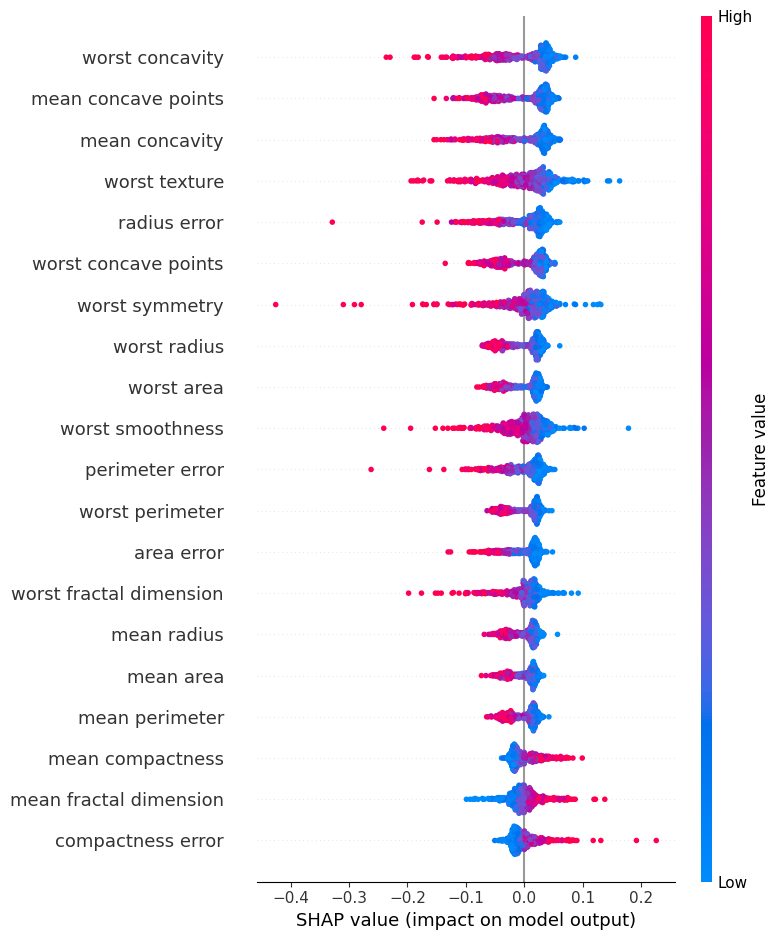

In [6]:
import shap

# 计算 SHAP 值
explainer = shap.KernelExplainer(best_model.predict, X_scaled)
shap_values = explainer.shap_values(X_scaled)

# 可视化 SHAP 值
shap.summary_plot(shap_values, X_scaled, feature_names=data.feature_names)
# Using 569 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
# shap.summary_plot(shap_values, X_scaled, feature_names=data.feature_names, plot_type="bar")
#
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_scaled[0], feature_names=data.feature_names)
# shap.force_plot(explainer.expected_value, shap_values, X_scaled, feature_names=data.feature_names)
# shap.force_plot(explainer.expected_value, shap_values, X_scaled, feature_names=data.feature_names, matplotlib=True)

# 6. 模型可解释性
使用 LIME 或 Shapley 技术来解释模型的预测结果。

In [7]:
import lime
import lime.lime_tabular

# 使用 LIME 进行局部解释
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_scaled, feature_names=data.feature_names, class_names=['malignant', 'benign'], verbose=True, mode='classification')
lime_exp = lime_explainer.explain_instance(X_scaled[0], best_model.predict_proba)
lime_exp.show_in_notebook(show_table=True)

AttributeError: This 'SVC' has no attribute 'predict_proba'

# 7. 可视化分析
准备各种高级可视化图表。

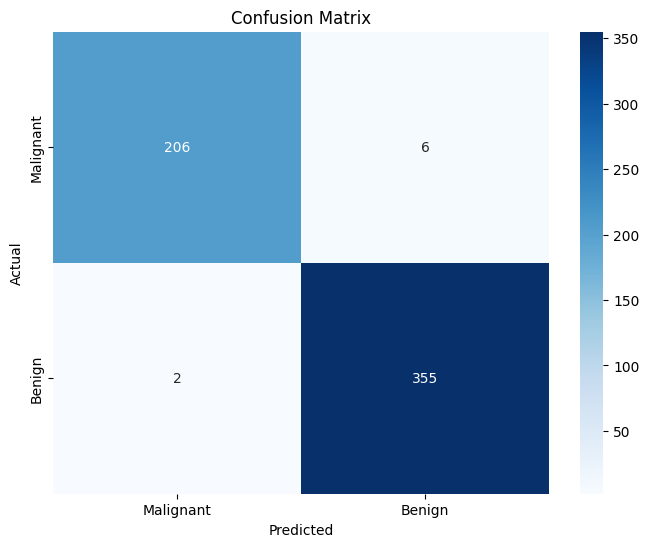

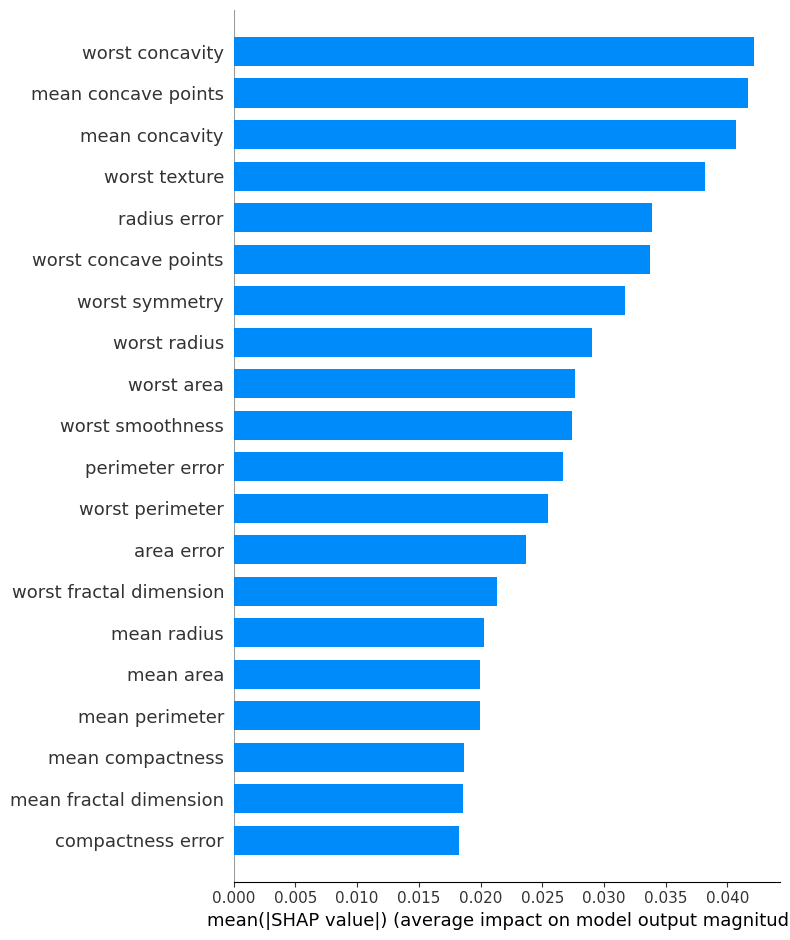

In [8]:
import seaborn as sns

# 混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC 曲线已在模型评估部分绘制

# 特征重要性条形图
shap.summary_plot(shap_values, X_scaled, feature_names=data.feature_names, plot_type="bar")

# 8. 模型保存和部署
保存训练好的模型，并编写示例代码展示如何使用保存的模型进行预测。

In [9]:
import joblib

# 保存模型
joblib.dump(best_model, 'best_svm_model.pkl')

# 加载模型并进行预测
loaded_model = joblib.load('best_svm_model.pkl')
sample_data = X_scaled[0].reshape(1, -1)
prediction = loaded_model.predict(sample_data)
print(f"Prediction for sample data: {prediction}")

Prediction for sample data: [0]
